In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from collections import OrderedDict
from torchvision.datasets import CIFAR100
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
from google.colab import files
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, embed_dim, image_resolution, vision_layers, vision_width, vision_heads, 
                 vision_patch_size):
        super().__init__()
        self.input_resolution = image_resolution
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=vision_width, kernel_size=vision_patch_size,
                               stride=vision_patch_size, bias=False)
        scale = vision_width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(vision_width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((image_resolution // vision_patch_size) ** 2 + 1, vision_width))
        self.ln_pre = nn.LayerNorm(vision_width)
        self.transformer = Transformer(vision_layers, vision_width, vision_heads)
        self.ln_post = nn.LayerNorm(vision_width)
        self.proj = nn.Parameter(scale * torch.randn(vision_width, embed_dim))

    def forward(self, x):
        x = self.conv1(x)
        x = x.reshape(x.shape[0], x.shape[1], -1)
        x = x.permute(0, 2, 1)
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)
        x = self.ln_post(x[:, 0, :])
        if self.proj is not None:
            x = x @ self.proj
        return x

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, width, heads, attention_mask=None):
        super().__init__()
        # GPT-2 Attention block
        # Masked MultiHeadAttnetion -> LayerNorm -> FF -> LayerNorm
        self.attn = nn.MultiheadAttention(width, heads)
        self.ln_1 = nn.LayerNorm(width)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(width, width * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(width * 4, width))
        ]))
        self.ln_2 = nn.LayerNorm(width)
        self.attn_mask = attention_mask
    
    def attention(self, x):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

In [ ]:
class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, transformer_layers, transformer_width, transformer_heads, attention_mask=None):
        super().__init__()
        self.resblocks = nn.Sequential(*[AttentionBlock(transformer_width, transformer_heads, attention_mask) 
                                     for _ in range(transformer_layers)])
        self.width = transformer_width
        self.layers = transformer_layers
        
    def forward(self, x):
        return self.resblocks(x)

In [ ]:
class CLIP(nn.Module):
    def __init__(self, embed_dim, image_resolution, vision_layers, vision_width, 
                 vision_patch_size, context_length, vocab_size, transformer_width,
                 transformer_heads, transformer_layers):
        super().__init__()
        vision_heads = vision_width // 64
        self.context_length = context_length
        self.visual = VisionTransformer(embed_dim, image_resolution, vision_layers, vision_width,
                                                vision_heads, vision_patch_size)
        self.transformer = Transformer(transformer_layers, transformer_width, transformer_heads,
                                       attention_mask=self.build_attention_mask())

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = nn.LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype
    
    def build_attention_mask(self):
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1) # Returns the upper triangular part of a matrix the other elements of the result tensor out are set to 0.
        return mask
    
    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)
        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection
        return x

    def encode_image(self, x):
        return self.visual(x.type(self.dtype))
    
    def forward(self, text, img):
        vision_output = self.vision_encoder(img)
        text_output = self.transformer(text)
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        return logits_per_image, logits_per_text

In [ ]:
# https://github.com/openai/CLIP/blob/d50d76daa670286dd6cacf3bcd80b5e4823fc8e1/clip/clip.py
MODELS = {
    "ViT-B/32": "https://github.com/mlfoundations/open_clip/releases/download/v0.2-weights/vit_b_32-quickgelu-laion400m_e31-d867053b.pt"
}

def _convert_image_to_rgb(image):
    return image.convert("RGB")

def load_params(param_path, device):
    def _transform(n_px):
        return Compose([
            Resize(n_px, interpolation=BICUBIC),
            CenterCrop(n_px),
            _convert_image_to_rgb,
            ToTensor(),
            Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
        ])
    
    import urllib
    if not os.path.exists("ViT-B-2.pt"):
        with urllib.request.urlopen(param_path) as source, open("ViT-B-2.pt", "wb") as output:
            with tqdm(total=int(source.headers.get("Content-Length")), ncols=80, unit='iB', unit_scale=True, unit_divisor=1024) as loop:
                while True:
                    buffer = source.read(8192)
                    if not buffer:
                        break

                    output.write(buffer)
                    loop.update(len(buffer))

    with open("ViT-B-2.pt", 'rb') as opened_file:
        checkpoint = torch.load(opened_file, map_location="cpu")
        if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint
        if next(iter(state_dict.items()))[0].startswith('module'):
            state_dict = {k[7:]: v for k, v in state_dict.items()}


    vision_width = state_dict["visual.conv1.weight"].shape[0]
    vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
    vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
    grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
    image_resolution = vision_patch_size * grid_size

    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith("transformer.resblocks")))
    
    model = CLIP(embed_dim, image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers)

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]
    
    model.load_state_dict(state_dict)
    model = model.eval()
    return model, _transform(model.visual.input_resolution)


# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = load_params(MODELS['ViT-B/32'], device)

In [ ]:
!pip3 install ftfy

In [ ]:
file = files.upload()

Saving bpe_simple_vocab_16e6.txt.gz to bpe_simple_vocab_16e6.txt.gz


In [ ]:
!ls

bpe_simple_vocab_16e6.txt.gz  sample_data  ViT-B-2.pt


In [ ]:
import gzip
import html
import os
from functools import lru_cache
import ftfy
import regex as re

# Tokenizer taken from https://github.com/openai/CLIP/blob/main/clip/simple_tokenizer.py

def default_bpe():
    return "bpe_simple_vocab_16e6.txt.gz"

def bytes_to_unicode():
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))

def get_pairs(word):
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()

def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

class Tokenizer:
    def __init__(self, bpe_path=default_bpe()):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text

_tokenizer = Tokenizer()

def tokenize(texts, context_length: int = 77, truncate: bool = False):
    if isinstance(texts, str):
        texts = [texts]

    sot_token = _tokenizer.encoder["<|startoftext|>"]
    eot_token = _tokenizer.encoder["<|endoftext|>"]
    all_tokens = [[sot_token] + _tokenizer.encode(text) + [eot_token] for text in texts]
    result = torch.zeros(len(all_tokens), context_length, dtype=torch.int)

    for i, tokens in enumerate(all_tokens):
        if len(tokens) > context_length:
            if truncate:
                tokens = tokens[:context_length]
                tokens[-1] = eot_token
            else:
                raise RuntimeError(f"Input {texts[i]} is too long for context length {context_length}")
        result[i, :len(tokens)] = torch.tensor(tokens)

    return result

In [ ]:
# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
image, class_id = cifar100[3647]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

#image = preprocess(Image.open("CLIP.png")).unsqueeze(0)
#text = tokenize(["a diagram", "a dog", "a cat"])

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(10)

# Print the result

print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


Files already downloaded and verified

Top predictions:

          turtle: 73.65%
       crocodile: 7.83%
            seal: 5.47%
           couch: 2.73%
           snail: 1.46%
           snake: 1.42%
        flatfish: 1.11%
          beaver: 1.01%
             ray: 0.78%
           trout: 0.68%


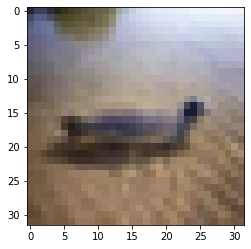

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()